In [ ]:
!pip install transformers datasets rouge-score nltk torch optuna bert-score


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from datasets import load_dataset
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, AdamW
from rouge_score import rouge_scorer
from torch.utils.data import DataLoader
from torch import nn
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score
from nltk.translate.meteor_score import meteor_score
import optuna
import os
import matplotlib.pyplot as plt

# Ensuring necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')


/home/desai226/.local/lib/python3.9/site-packages/transformers/loss/loss_for_object_detection.py:28: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import linear_sum_assignment
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desai226/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/desai226/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Device set-up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
pegasus_model_name = 'google/pegasus-large'
print(f"Loading Pegasus model: {pegasus_model_name}")
tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(device)


Loading Pegasus model: google/pegasus-large


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Function to remove rows with missing data
def remove_missing_data(dataset, columns):
    return dataset.filter(lambda x: all(x[col] is not None for col in columns))


In [ ]:
# Function to load and clean data
def load_and_clean_data():
    train_data = load_dataset("ragha92/FNS_Summarization", split="train")
    validation_data = load_dataset("ragha92/FNS_Summarization", split="validation")
    test_data = load_dataset("ragha92/FNS_Summarization", split="test")

    columns = ['Annual Reports', 'Gold Summaries']
    train_data = remove_missing_data(train_data, columns)
    validation_data = remove_missing_data(validation_data, columns)
    test_data = remove_missing_data(test_data, columns)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_clean_data()
print("Datasets loaded and cleaned.")


Datasets loaded and cleaned.


In [ ]:
# Function for Suggesting best hyperparameters
def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_beams = trial.suggest_int('num_beams', 2, 10)
    length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
    max_length = trial.suggest_int('max_length', 256, 1024, step=64)
    min_length = trial.suggest_int('min_length', 50, 300, step=50)

    if min_length >= max_length:
        return float('inf')

    # Model training setup
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        input_texts = batch['Annual Reports']
        target_summaries = batch['Gold Summaries']

        inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

        outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Displaing best parameters
print("Best Hyperparameters:")
print(study.best_params)


[I 2024-12-01 18:10:41,755] A new study created in memory with name: no-name-1c3727ef-78a8-4104-af86-6cc1d5ddf8e6
/tmp/ipykernel_89843/325509299.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/tmp/ipykernel_89843/325509299.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
/home/desai226/.local/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` t

Best Hyperparameters:
{'learning_rate': 1.3102880767975398e-05, 'num_beams': 9, 'length_penalty': 1.7649659369712785, 'max_length': 512, 'min_length': 100}


In [ ]:
# Function for text summarization
def summarize_text_pegasus(article, num_beams=3, length_penalty=1.5, max_length=512, min_length=200):
    input_ids = tokenizer.encode(article, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        min_length=min_length,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
# Model fine tuning
def fine_tune_model(train_data, epochs=3, learning_rate=5e-5):
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            input_texts = batch['Annual Reports']
            target_summaries = batch['Gold Summaries']

            inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
            targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

            outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

best_params = study.best_params
fine_tune_model(train_data, epochs=3, learning_rate=best_params['learning_rate'])


Epoch 1/3, Loss: 1.8483518487294612
Epoch 2/3, Loss: 1.802163437225865
Epoch 3/3, Loss: 1.7672180145364074


In [ ]:
from nltk.tokenize import word_tokenize
# Model Evaluation
def evaluate_model_extended(dataset):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'bleu': [], 'meteor': [], 'bertscore': []}
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    for item in dataset:
        article = preprocess_text(item['Annual Reports'])
        gold_summary = preprocess_text(item['Gold Summaries'])
        if article:
            generated_summary = summarize_text_pegasus(
                article,
                num_beams=best_params['num_beams'],
                length_penalty=best_params['length_penalty'],
                max_length=best_params['max_length'],
                min_length=best_params['min_length']
            )
            references.append(gold_summary)
            candidates.append(generated_summary)

            score_rouge = scorer.score(gold_summary, generated_summary)
            scores['rouge1'].append(score_rouge['rouge1'].fmeasure)
            scores['rouge2'].append(score_rouge['rouge2'].fmeasure)
            scores['rougeL'].append(score_rouge['rougeL'].fmeasure)
            bleu_score = sentence_bleu([gold_summary.split()], generated_summary.split(), smoothing_function=smooth)
            scores['bleu'].append(bleu_score)

              # Tokenizing summaries for METEOR
            tokenized_gold_summary = word_tokenize(gold_summary)
            tokenized_generated_summary = word_tokenize(generated_summary)

            # METEOR score
            meteor = meteor_score([tokenized_gold_summary], tokenized_generated_summary)
            scores['meteor'].append(meteor)

    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    scores['bertscore'] = F1.numpy().tolist()

    avg_rouge1 = sum(scores['rouge1']) / len(scores['rouge1'])
    avg_rouge2 = sum(scores['rouge2']) / len(scores['rouge2'])
    avg_rougeL = sum(scores['rougeL']) / len(scores['rougeL'])
    avg_bleu = sum(scores['bleu']) / len(scores['bleu'])
    avg_meteor = sum(scores['meteor']) / len(scores['meteor'])
    avg_bertscore = sum(scores['bertscore']) / len(scores['bertscore'])

    metrics = [avg_rouge1, avg_rouge2, avg_rougeL, avg_bleu, avg_meteor, avg_bertscore]
    metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR', 'BERTScore']
    return metrics, metric_names

# Evaluation on validation data
metrics, metric_names = evaluate_model_extended(validation_data)
print("Evaluation Metrics:")
for metric_name, value in zip(metric_names, metrics):
    print(f"{metric_name}: {value:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 7.11 seconds, 36.13 sentences/sec
Evaluation Metrics:
ROUGE-1: 0.2334
ROUGE-2: 0.1312
ROUGE-L: 0.1738
BLEU: 0.0792
METEOR: 0.1853
BERTScore: 0.7959


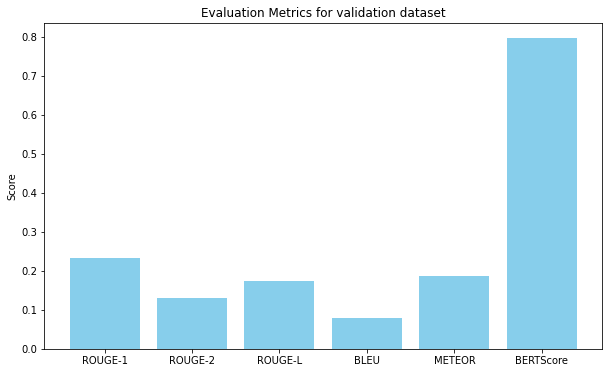

In [ ]:
# Function to visulalize Validation data metrics
def visualize_metrics(metrics, metric_names):
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics, color='skyblue')
    plt.title("Evaluation Metrics for validation dataset")
    plt.ylabel("Score")
    plt.show()

visualize_metrics(metrics, metric_names)


In [ ]:
# Evaluation on test data
test_metrics, test_metric_names = evaluate_model_extended(test_data)
print("Test Data Evaluation Metrics:")
for metric_name, value in zip(test_metric_names, test_metrics):
    print(f"{metric_name}: {value:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 6.57 seconds, 39.13 sentences/sec
Test Data Evaluation Metrics:
ROUGE-1: 0.2121
ROUGE-2: 0.1095
ROUGE-L: 0.1464
BLEU: 0.0609
METEOR: 0.1585
BERTScore: 0.7924


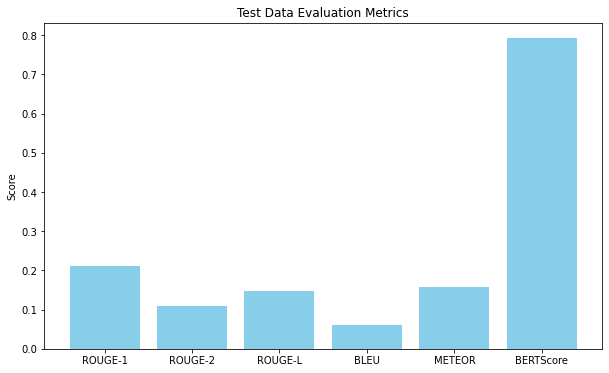

In [ ]:
# Function to visualize test data metrics
def visualize_test_metrics(test_metrics, test_metric_names):
    plt.figure(figsize=(10, 6))
    plt.bar(test_metric_names, test_metrics, color='skyblue')
    plt.title("Test Data Evaluation Metrics")
    plt.ylabel("Score")
    plt.show()

visualize_test_metrics(test_metrics, test_metric_names)


In [ ]:

best_params = study.best_params

# Function to display gold summaries and generated summaries for the first few records
def display_sample_summaries(dataset, num_samples=3):
    model.eval()
    sample_summaries = []

    for idx, item in enumerate(dataset):
        if idx >= num_samples:
            break

        input_text = item['Annual Reports']
        gold_summary = item['Gold Summaries']

        # Prediction generation
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        outputs = model.generate(
            inputs['input_ids'],
            max_length=best_params['max_length'],
            min_length=best_params['min_length'],
            num_beams=best_params['num_beams'],
            length_penalty=best_params['length_penalty']
        )
        generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

        sample_summaries.append({
            'input_text': input_text,
            'gold_summary': gold_summary,
            'generated_summary': generated_summary
        })

    # Displaying the summaries
    for idx, summary in enumerate(sample_summaries):
        print(f"Sample {idx + 1}:")
        print(f"Input Text (first 500 characters): {summary['input_text'][:500]}...")  # Display first 500 characters of input
        print(f"Gold Summary: {summary['gold_summary'][:1500]}")  # Display gold summary (up to 1500 characters)
        print(f"Generated Summary: {summary['generated_summary'][:1500]}")  # Display generated summary (up to 1500 characters)
        print("\n" + "="*50 + "\n")

# Displaying summaries for the first 3 records in the test dataset
display_sample_summaries(test_data, num_samples=3)


Sample 1:
Input Text (first 500 characters):  renew holdings plc annual report and accounts 2011
delivering 
engineering services 
to uk infrastructure
renew holdings plc annual report and accounts 2011 highlights
  engineering services revenue up 39 to £1767m 
2010 £1274m
	 	 engineering 	 services 	 adjusted 	 operating 	 profit 	
up 78 to £74m 2010 £42m 
  group order book of £285m 2010 £304m including 
engineering services order book up 118 to £179m 
2010 £82m 
  acquisition of engineering services business amco 
now fully integrated
 ...
Gold Summary:  06
renew holdings plc
annual report and accounts 2011 chief executive’s review
renew is now positioned as an engineering 
services group supporting uk infrastructure 
2011 	 has 	 been 	 a 	 significant 	 year 	 for 	 the 	 group 	
which with further organic growth and the 
acquisition of amco has achieved its target 
of shifting the balance of operations into 
engineering services 
engineering services
engineering services revenue 